<a href="https://colab.research.google.com/github/EG-scape/redcode/blob/main/VRT_demo_on_Video_Restoration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VRT Online Demo on Video Restoration

[![arXiv](https://img.shields.io/badge/arXiv-Paper-<COLOR>.svg)](https://arxiv.org/abs/2201.12288)
[![GitHub Stars](https://img.shields.io/github/stars/JingyunLiang/VRT?style=social)](https://github.com/JingyunLiang/VRT)
[![download](https://img.shields.io/github/downloads/JingyunLiang/VRT/total.svg)](https://github.com/JingyunLiang/VRT/releases)
![visitors](https://visitor-badge.glitch.me/badge?page_id=jingyunliang/VRT)

This is a **VRT online demo on Video Restoration** of our paper [''VRT: A Video Restoration Transformer''](https://arxiv.org/abs/2201.12288).

VRT ahcieves state-of-the-art performance **(up to 2.16dB)** in
- video SR (REDS, Vimeo90K, Vid4 and UDM10)
- video deblurring (GoPro, DVD and REDS)
- video denoising (DAVIS and Set8)
- video frame interpolation (Vimeo90K, UCF101, DAVIS)
- space-time video SR (Vimeo90K, Vid4)

<img src="https://raw.githubusercontent.com/JingyunLiang/VRT/main/assets/vsr_visual.jpeg" width="100%">
<img src="https://raw.githubusercontent.com/JingyunLiang/VRT/main/assets/vdb_visual.jpeg" width="100%">



# 1. Preparations
Before start, make sure that you choose
* Runtime Type = Python 3
* Hardware Accelerator = GPU
* Broswer != Firefox (cannot upload images in step 2)

in the **Runtime** menu -> **Change runtime type**

Then, we clone the repository, set up the envrironment, and download the pre-trained model.

In [1]:
!rm -r VRT
# Clone VRT
!git clone https://github.com/JingyunLiang/VRT.git
%cd VRT
!pip install -r requirements.txt

rm: cannot remove 'VRT': No such file or directory
Cloning into 'VRT'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 99 (delta 21), reused 3 (delta 3), pack-reused 70 (from 1)
Receiving objects: 100% (99/99), 13.06 MiB | 38.33 MiB/s, done.
Resolving deltas: 100% (31/31), done.
/content/VRT


# 2. Upload Images

Upload the images to be processed by VRT

In [ ]:
import os
import glob
from google.colab import files
import shutil
print(' Note1: You can upload a single video/ video frames as a batch. \n Note2: If you just to want to replicate the results in the paper, you can skip this step (we have enabled automatic download in the code).\n Note3: You may need Chrome to enable file uploading!\n Note4: Our model is trained on simple synthetic videos (e.g., bicubic). It may not perform well on real-world videos.\n')
input_folder = None

# upload images
!rm -r testsets/*
!rm -r results/*
os.mkdir('testsets/uploaded')
os.mkdir('testsets/uploaded/000')
uploaded = files.upload()
for filename in uploaded.keys():
  is_image = (filename.split('.')[-1].lower() in ['png','jpeg','jpg','tiff','bmp','tif',])
  input_folder = 'testsets/uploaded/000' if is_image else 'testsets/uploaded'
  dst_path = os.path.join(input_folder, filename)
  print(f'move {filename} to {dst_path}')
  shutil.move(filename, dst_path)

  if not is_image: # image or video
    print(f'extracting the video as frames to {input_folder}/000')
    os.system(f'ffmpeg -i testsets/uploaded/{filename} -qscale:v 1 -qmin 1 -qmax 1 -vsync 0  {input_folder}/000/frame%08d.png')
    os.remove(f'testsets/uploaded/{filename}')

!ls testsets/uploaded/000

 Note1: You can upload video/ video frmaes as a batch. 
 Note2: If you just to want to replicate the results in the paper, you can skip this step (we have enabled automatic download in the code).
 Note3: You may need Chrome to enable file uploading!
 Note4: Our model is trained on simple synthetic videos (e.g., bicubic). It may not perform well on real-world videos.

rm: cannot remove 'results/*': No such file or directory


Saving 00000000.png to 00000000.png
Saving 00000001.png to 00000001.png
Saving 00000002.png to 00000002.png
Saving 00000003.png to 00000003.png
Saving 00000004.png to 00000004.png
Saving 00000005.png to 00000005.png
Saving 00000006.png to 00000006.png
Saving 00000007.png to 00000007.png
Saving 00000008.png to 00000008.png
Saving 00000009.png to 00000009.png
Saving 00000010.png to 00000010.png
Saving 00000011.png to 00000011.png
move 00000000.png to testsets/uploaded/000/00000000.png
move 00000001.png to testsets/uploaded/000/00000001.png
move 00000002.png to testsets/uploaded/000/00000002.png
move 00000003.png to testsets/uploaded/000/00000003.png
move 00000004.png to testsets/uploaded/000/00000004.png
move 00000005.png to testsets/uploaded/000/00000005.png
move 00000006.png to testsets/uploaded/000/00000006.png
move 00000007.png to testsets/uploaded/000/00000007.png
move 00000008.png to testsets/uploaded/000/00000008.png
move 00000009.png to testsets/uploaded/000/00000009.png
move 000

# 3. Inference


In [ ]:
# Testing arguments
# --task: 001_VRT_videosr_bi_REDS_6frames/
#         002_VRT_videosr_bi_REDS_16frames/
#         003_VRT_videosr_bi_Vimeo_7frames/
#         004_VRT_videosr_bd_Vimeo_7frames/
#         005_VRT_videodeblurring_DVD/
#         006_VRT_videodeblurring_GoPro/
#         007_VRT_videodeblurring_REDS/
#         008_VRT_videodenoising_DAVIS
# --folder_lq: path to low-quality videos. If you have uploaded your own video, it will use yours.
#              Otherwise, it will automatically download benchmark datasets and test on them.
# --folder_gt: path to ground-truth videos. No use for your own video. Only support benchmark datasets.
# --tile: temporal, height and width testing sizes. For example, [40,128,128] means testing the video as 40x128x128 video clips.
#         Reduce it if out-of-memory (at the expense of lower performance).
# --tile_overlap: tile overlapping size. No need to modify it.



##                                                ### Benchmak testing  ###
## Note: Due to Colab GPU memory limitation, we use smaller --tile here, which may lead to different performance from the paper.
## Please refer to https://github.com/JingyunLiang/VRT#quick-testing for official arguments.)

## 001, video sr trained on REDS (6 frames), tested on REDS4
!python main_test_vrt.py --task 001_VRT_videosr_bi_REDS_6frames --folder_lq testsets/REDS4/sharp_bicubic --folder_gt testsets/REDS4/GT --tile 40 64 64 --tile_overlap 2 20 20 --num_workers 2 --save_result

## 002, video sr trained on REDS (16 frames), tested on REDS4
# !python main_test_vrt.py --task 002_VRT_videosr_bi_REDS_16frames --folder_lq testsets/REDS4/sharp_bicubic --folder_gt testsets/REDS4/GT --tile 40 64 64 --tile_overlap 2 20 20 --num_workers 2 --save_result

## 003, video sr trained on Vimeo (bicubic), tested on Vid4 and Vimeo
# !python main_test_vrt.py --task 003_VRT_videosr_bi_Vimeo_7frames --folder_lq testsets/Vid4/BIx4 --folder_gt testsets/Vid4/GT --tile 32 64 64 --tile_overlap 2 20 20 --num_workers 2
# !python main_test_vrt.py --task 003_VRT_videosr_bi_Vimeo_7frames --folder_lq testsets/vimeo90k/vimeo_septuplet_matlabLRx4/sequences --folder_gt testsets/vimeo90k/vimeo_septuplet/sequences --tile 8 0 0 --tile_overlap 0 20 20 --num_workers 2 --save_result

## 004, video sr trained on Vimeo (blur-downsampling), tested on Vid4, UDM10 and Vimeo
# !python main_test_vrt.py --task 004_VRT_videosr_bd_Vimeo_7frames --folder_lq testsets/Vid4/BDx4 --folder_gt testsets/Vid4/GT --tile 32 64 64 --tile_overlap 2 20 20 --num_workers 2 --save_result
# !python main_test_vrt.py --task 004_VRT_videosr_bd_Vimeo_7frames --folder_lq testsets/UDM10/BDx4 --folder_gt testsets/UDM10/GT --tile 32 64 64 --tile_overlap 2 20 20 --num_workers 2 --save_result
# !python main_test_vrt.py --task 004_VRT_videosr_bd_Vimeo_7frames --folder_lq testsets/vimeo90k/vimeo_septuplet_BDLRx4/sequences --folder_gt testsets/vimeo90k/vimeo_septuplet/sequences --tile 8 0 0 --tile_overlap 0 20 20 --num_workers 2 --save_result

## 005, video deblurring trained and tested on DVD
# !python main_test_vrt.py --task 005_VRT_videodeblurring_DVD --folder_lq testsets/DVD10/test_GT_blurred --folder_gt testsets/DVD10/test_GT --tile 12 128 128 --tile_overlap 2 20 20 --num_workers 2 --save_result

## 006, video deblurring trained and tested on GoPro
# !python main_test_vrt.py --task 006_VRT_videodeblurring_GoPro --folder_lq testsets/GoPro11/test_GT_blurred --folder_gt testsets/GoPro11/test_GT --tile 12 128 128 --tile_overlap 2 20 20 --num_workers 2 --save_result

## 007, video deblurring trained on REDS, tested on REDS4
# !python main_test_vrt.py --task 007_VRT_videodeblurring_REDS --folder_lq testsets/REDS4/blur --folder_gt testsets/REDS4/GT --tile 12 128 128 --tile_overlap 2 20 20 --num_workers 2 --save_result

## 008, video denoising trained on DAVIS (noise level 0-50) and tested on Set8 and DAVIS
# !python main_test_vrt.py --task 008_VRT_videodenoising_DAVIS --sigma 10 --folder_lq testsets/Set8 --folder_gt testsets/Set8 --tile 12 128 128 --tile_overlap 2 20 20 --num_workers 2 --save_result
# !python main_test_vrt.py --task 008_VRT_videodenoising_DAVIS --sigma 10  --folder_lq testsets/DAVIS-test --folder_gt testsets/DAVIS-test --tile 12 128 128 --tile_overlap 2 20 20 --num_workers 2 --save_result

## 009, video frame interpolation trained on Vimeo (single frame interpolation), tested on Viemo, UCF101 and DAVIS-train
# !python main_test_vrt.py --task 009_VRT_videofi_Vimeo_4frames --folder_lq testsets/vimeo90k/vimeo_septuplet/sequences --folder_gt testsets/vimeo90k/vimeo_septuplet/sequences --tile 0 0 0 --tile_overlap 0 0 0 --num_workers 2 --save_result
# !python main_test_vrt.py --task 009_VRT_videofi_Vimeo_4frames --folder_lq testsets/UCF101 --folder_gt testsets/UCF101 --tile 0 0 0 --tile_overlap 0 0 0 --num_workers 2 --save_result
# !python main_test_vrt.py --task 009_VRT_videofi_Vimeo_4frames --folder_lq testsets/DAVIS-train --folder_gt testsets/DAVIS-train --tile 0 256 256 --tile_overlap 0 20 20 --num_workers 2 --save_result

## 010, space-time video sr, using pretrained models from 003 and 009, tested on Vid4 and Viemo
# Please refer to 003 and 009


##                                       ### test your own video (no ground-truth) ###
# !python main_test_vrt.py --task 001_VRT_videosr_bi_REDS_6frames --folder_lq testsets/uploaded --tile 6 128 128 --tile_overlap 2 20 20 --num_workers 2 --save_result


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/content/VRT/models/network_vrt.py:716: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = temperature ** (2 * (dim_t // 2) / num_pos_feats)
downloading model model_zoo/vrt/001_VRT_videosr_bi_REDS_6frames.pth
using dataset from testsets/uploaded
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader wil

# 4. Visualization

 Note: Due to Colab GPU memory limitation, we use smaller --tile here, which may lead to different performance from the paper. 
 Please refer to https://github.com/JingyunLiang/VRT#quick-testing for official arguments.



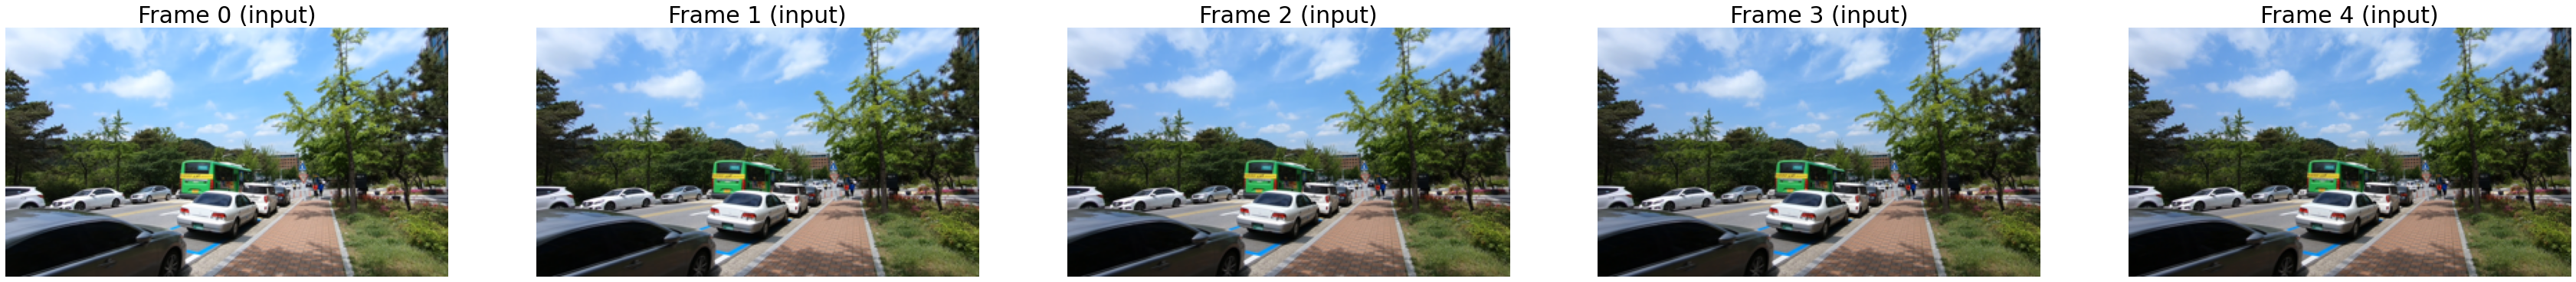

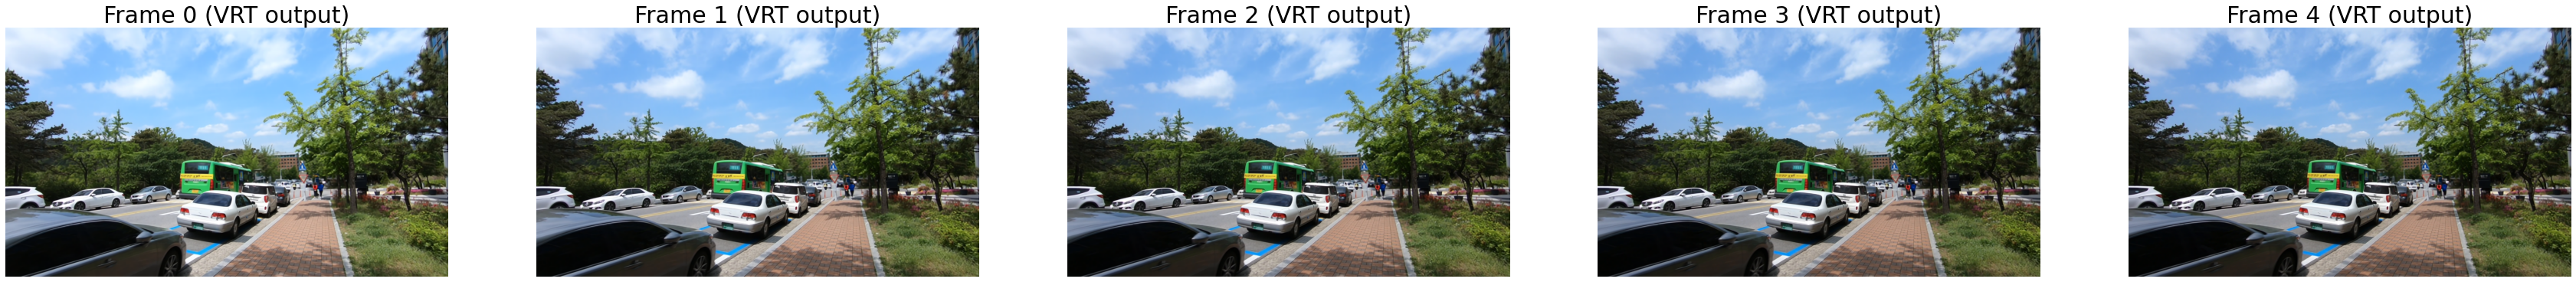

In [ ]:
# utils for visualization
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

def display(img1, name='input'):
  total_figs = 5
  fig = plt.figure(figsize=(total_figs*12, 14))
  ax1 = fig.add_subplot(1, total_figs, 1)
  plt.title(f'Frame 0 ({name})', fontsize=30)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, total_figs, 2)
  plt.title(f'Frame 1 ({name})', fontsize=30)
  ax2.axis('off')
  ax3 = fig.add_subplot(1, total_figs, 3)
  plt.title(f'Frame 2 ({name})', fontsize=30)
  ax3.axis('off')
  ax4 = fig.add_subplot(1, total_figs, 4)
  plt.title(f'Frame 3 ({name})', fontsize=30)
  ax4.axis('off')
  ax5 = fig.add_subplot(1, total_figs, 5)
  plt.title(f'Frame 4 ({name})', fontsize=30)
  ax5.axis('off')
  ax1.imshow(img1[0])
  ax2.imshow(img1[1])
  ax3.imshow(img1[2])
  ax4.imshow(img1[3])
  ax5.imshow(img1[4])

# display video by frames
print(' Note: Due to Colab GPU memory limitation, we use smaller --tile here, which may lead to different performance from the paper. \n Please refer to https://github.com/JingyunLiang/VRT#quick-testing for official arguments.\n')

img = []
for path in sorted(Path('testsets').rglob('*.png'))[:10]:
  img.append(cv2.cvtColor(cv2.imread(f'{path}'), cv2.COLOR_BGR2RGB))
display(img, 'input')
img = []
for path in sorted(Path('results').rglob('*.png'))[:10]:
  img.append(cv2.cvtColor(cv2.imread(f'{path}'), cv2.COLOR_BGR2RGB))
display(img, 'VRT output')

# 5. Download Results


In [ ]:
# Download the results
zip_filename = 'VRT_result.zip'
if os.path.exists(zip_filename):
  os.remove(zip_filename)
os.system(f"zip -r -j {zip_filename} results/*")
files.download(zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>